# Modelling

This is the fifth notebook in a series that investigates the GHCN climate and UCDP conflict datasets to evaluate to what extent we can predict **conflict intensity** (measured as deaths per day) from a range of climate data gathered from stations in the vicinity of that conflict.


### Goal of this Notebook

In this notebook we will:
- build a baseline model by predicting the mean
- build 3 models to 
- tweak these models using hyperparameter tuning where applicable
- evaluate the model performances
- select our final model

### Executive Summary

In this notebook, we first ...


### Outline

This notebook is structured as follows:

**1. Importing the Necessary Libraries** 


**2. Loading the Training and Test Sets**


**3. Baseline: Predicting the Mean**


**4. Model 1: Linear Regression**


**5. Model 2: Random Forest Regression**


**6. Model 3: Lasso Regression**


# 1. Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon 
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

import contextily as ctx
import warnings
import datetime
import re

# 2. Loading Training and Test Sets

Below, we load the training and test sets created in the previous notebook *04-rrp-preprocessing*. The dat

In [2]:
# load datasets as dataframes
df_X_train = pd.read_csv('/Users/richard/Desktop/data/processed/X_train_unscaled.csv', index_col=0)
df_X_test = pd.read_csv('/Users/richard/Desktop/data/processed/X_test_unscaled.csv', index_col=0)
df_X_train_sc = pd.read_csv('/Users/richard/Desktop/data/processed/X_train_scaled.csv', index_col=0)
df_X_test_sc = pd.read_csv('/Users/richard/Desktop/data/processed/X_test_scaled.csv', index_col=0)
df_y_train = pd.read_csv('/Users/richard/Desktop/data/processed/y_train_unscaled.csv', index_col=0)
df_y_test = pd.read_csv('/Users/richard/Desktop/data/processed/y_test_unscaled.csv', index_col=0)

In [3]:
# convert to numpy arrays
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
X_train_sc = df_X_train_sc.to_numpy()
X_test_sc = df_X_test_sc.to_numpy()
y_train = df_y_train.to_numpy()
y_test = df_y_test.to_numpy()

In [4]:
# verify X and y train have same number of rows
X_train_sc.shape, y_train.shape

((10243, 32), (10243, 1))

In [5]:
# verify X and y test have same number of rows
X_test_sc.shape, y_test.shape

((4391, 32), (4391, 1))

In [6]:
# verify X scaled and unscaled have the same shape
X_test.shape, X_test_sc.shape, X_train.shape, X_train_sc.shape

((4391, 32), (4391, 32), (10243, 32), (10243, 32))

In [7]:
# reshape y_train and y_test into correct size
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_train.shape, y_test.shape

((10243,), (4391,))

This looks good.

As reminder, below we list all the features names and save the names of our target and predictor features, respectively.

In [8]:
df_india = pd.read_csv('/Users/richard/Desktop/data/processed/df_india_final_for_model.csv', index_col=0)
df_india.columns

Index(['death_rate', 'PRCP_zone_1973_77', 'PRCP_zone_1983_87',
       'PRCP_zone_1993_97', 'PRCP_zone_2003_07', 'PRCP_zone_2015_19',
       'TAVG_zone_1973_77', 'TAVG_zone_1983_87', 'TAVG_zone_1993_97',
       'TAVG_zone_2003_07', 'TAVG_zone_2015_19', 'TMAX_zone_1973_77',
       'TMAX_zone_1983_87', 'TMAX_zone_1993_97', 'TMAX_zone_2003_07',
       'TMAX_zone_2015_19', 'TMIN_zone_1973_77', 'TMIN_zone_1983_87',
       'TMIN_zone_1993_97', 'TMIN_zone_2003_07', 'TMIN_zone_2015_19',
       'PRCP_zone_sameyear', 'TAVG_zone_sameyear', 'TMAX_zone_sameyear',
       'TMIN_zone_sameyear', 'PRCP_change_1973_2019', 'TAVG_change_1973_2019',
       'TMAX_change_1973_2019', 'TMIN_change_1973_2019',
       'PRCP_change_1973_sameyear', 'TAVG_change_1973_sameyear',
       'TMAX_change_1973_sameyear', 'TMIN_change_1973_sameyear'],
      dtype='object')

In [190]:
df_india.shape

(14634, 33)

In [10]:
X_labels = list(df_india.drop('death_rate', axis=1).columns)
y_label = 'death_rate'

# 3. Baseline: Predicting the Mean

To create a baseline for our models, let's predict the mean of our target feature *deaths_civilians* for all rows and evaluate its performance.

## 3.1. Training Dummy Regressor Model

In [11]:
# get mean of y_train
train_mean = y_train.mean()
train_mean

2.4907441937991988

In [12]:
# fit a dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train_sc, y_train)
dumb_reg.constant_

array([[2.49074419]])

In [13]:
# use dummy regressor to predict mean for training set
y_tr_pred = dumb_reg.predict(X_train_sc)
y_tr_pred

array([2.49074419, 2.49074419, 2.49074419, ..., 2.49074419, 2.49074419,
       2.49074419])

In [14]:
# same for test set
y_te_pred = dumb_reg.predict(X_test_sc)
y_te_pred

array([2.49074419, 2.49074419, 2.49074419, ..., 2.49074419, 2.49074419,
       2.49074419])

## 3.2. Evaluation

Below, we evaluate the performance of the Dummy Regressor which predict the mean for all rows, as a baseline against which to compare our future models.

To do this, we calculate:
- the r2 score
- the mean absolute error
- the mean squared error

In [121]:
# calculate r2 scores on train and test sets
r2_base = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
r2_base

(0.0, -0.00018094252875777705)

In [122]:
# calculate mean absolute error on train and test sets
mae_base = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
mae_base

(1.9529705211039985, 2.0049907766383193)

In [123]:
# calculate mean squared error on train and test sets
mse_base = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
mse_base

(19.940635758949913, 16.573842186988312)

### Interpretation

- As expected, the model that predicts the mean yields an r2 score of 0 on training set and does slightly worse on the test set.
- The mean absolute error is 1.95 on the training set and 2.00 on the test set. Interesting that it's a relatively low error - this is likely because our target feature is skewed, with 90% of the data between 0 and 5.

In [20]:
df_y_train.death_rate.quantile(0.9)

5.0

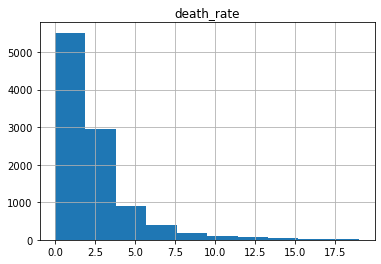

In [21]:
df_y_train[df_y_train.death_rate < 20].hist(bins=10);

# 5. Model 1: Linear Regression

In this section, we build our first model: a linear regression model that will predict our target feature *total_deaths* from our predictor features.

We will train this model as part of a SciKit-Learn pipeline that will:
- impute missing values (with median or mean)
- standardize our numerical data
- train the model
- calculate its performance

## 5.1. Training Linear Regression Model

In [22]:
# create pipeline
pipe_lm_median = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [23]:
%%time
# fit pipeline to our training data
pipe_lm_median.fit(X_train, y_train)

CPU times: user 96.9 ms, sys: 26.3 ms, total: 123 ms
Wall time: 139 ms


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

## 5.2. Cross-Validation and Evaluation

In [24]:
# cross-validate the pipeline with 5 folds
lm_median_cv_results = cross_validate(pipe_lm_median, X_train, y_train, cv=5)

In [25]:
# get the cross-validation scores
lm_median_cv_scores = lm_median_cv_results['test_score']
lm_median_cv_scores

array([ 0.05132387, -0.07312218, -0.04605202,  0.05260079,  0.01362836])

In [124]:
# get the mean score and std
mean_r2_lm_median = np.mean(lm_median_cv_scores)
std_r2_lm_median = np.std(lm_median_cv_scores)

mean_r2_lm_median, std_r2_lm_median

(-0.00032423645160137846, 0.051095656381917785)

In [27]:
# use model to predict y
y_train_pred_lm = pipe_lm_median.predict(X_train)
y_test_pred_lm = pipe_lm_median.predict(X_test)

Let's also get the MAE and MSE.

In [125]:
# calculate mean absolute error on train and test sets
mae_lm_median = mean_absolute_error(y_train, y_train_pred_lm), mean_absolute_error(y_test, y_test_pred_lm)
mae_lm_median

(1.9124737298673562, 1.9652851074446702)

In [126]:
# calculate mean squared error on train and test sets
mse_lm_median = mean_squared_error(y_train, y_train_pred_lm), mean_squared_error(y_test, y_test_pred_lm)
mse_lm_median

(18.96726740090534, 16.311337637008453)

### Interpretation

- The out-of-the-box linear regression model seems to do no better than predicting the mean, as indicated by an r2 score of just below 0.
- There is a slight reducation in the MAE, which indicates it may be doing a little better than our baseline model.
- The mean absolute error is relatively low, but that has more to do with the distribution of our target feature.
- Same for the mean squared error.

All in all, this model performs poorly. This is not unexpected. In the EDA phase of this project, we already saw that our target feature was poorly correlated with our predictor features.

Let's just see if imputing missing values with the mean makes any difference.

## 5.3. Linear Regression, Imputing with Mean

In [31]:
# create pipeline
pipe_lm_mean = make_pipeline(
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LinearRegression()
)

In [32]:
# fit pipeline to our training data
pipe_lm_mean.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

## 5.4. Cross-Validation and Evaluation

In [33]:
# cross-validate the pipeline with 5 folds
lm_mean_cv_results = cross_validate(pipe_lm_mean, X_train, y_train, cv=5)

In [34]:
# get the cross-validation scores
lm_mean_cv_scores = lm_mean_cv_results['test_score']
lm_mean_cv_scores

array([ 0.05263554, -0.13105551, -0.04608865,  0.05262263,  0.01359249])

In [35]:
# get the mean score and std
np.mean(lm_mean_cv_scores), np.std(lm_mean_cv_scores)

(-0.01165870059917642, 0.06977747680760303)

In [36]:
# use model to predict y
y_train_pred_mean = pipe_lm_mean.predict(X_train)
y_test_pred_mean = pipe_lm_mean.predict(X_test)

Let's also get the MAE and MSE.

In [38]:
# calculate mean absolute error on train and test sets
mae_lm = mean_absolute_error(y_train, y_train_pred_mean), mean_absolute_error(y_test, y_test_pred_mean)
mae_lm

(1.9124898066218106, 1.9656781679774713)

In [39]:
# calculate mean squared error on train and test sets
mse_lm = mean_squared_error(y_train, y_train_pred_mean), mean_squared_error(y_test, y_test_pred_mean)
mse_lm

(18.967649377849973, 16.31735077279609)

Imputing missing values using the mean instead of the median seems slightly decrease model performance. Let's stick with the median.

## 5.5. Refining the Linear Regression Model

In the pipeline above, we made use of all the 32 weather features. It's possible that taking a subset of the best features will do better. We will now refine our pipeline by including sklearn's SelectKBest feature selection function; employing the *f_regression* scoring function. We will start by selecting the default of 10 best features.

### 5.5.1. Selecting K=10 Best Features

In [40]:
# update our pipeline
pipe_lm_K = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [41]:
%%time
# fit the pipeline
pipe_lm_K.fit(X_train, y_train)

CPU times: user 75 ms, sys: 13.8 ms, total: 88.7 ms
Wall time: 89.9 ms


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x1a238a4440>)),
                ('linearregression', LinearRegression())])

### 5.5.2. Cross-Validation & Evaluation

In [42]:
# cross-validate the pipeline with 5 folds
lm_K_cv_results = cross_validate(pipe_lm_K, X_train, y_train, cv=5)

In [43]:
# get the cross-validation scores
lm_K_cv_scores = lm_K_cv_results['test_score']
lm_K_cv_scores

array([ 0.01008675, -0.01653222, -0.00184931,  0.01091628, -0.00800705])

In [44]:
# get the mean score and std
np.mean(lm_K_cv_scores), np.std(lm_K_cv_scores)

(-0.0010771112480068234, 0.010544705147599157)

In [45]:
# predict target features
y_train_pred_lm_2 = pipe_lm_K.predict(X_train)
y_test_pred_lm_2 = pipe_lm_K.predict(X_test)

Let's also get the MAE and MSE

In [47]:
# calculate mean absolute error on train and test sets
mae_lm = mean_absolute_error(y_train, y_train_pred_lm_2), mean_absolute_error(y_test, y_test_pred_lm_2)
mae_lm

(1.9602684393761314, 2.010514241965409)

In [48]:
# calculate mean squared error on train and test sets
mse_lm = mean_squared_error(y_train, y_train_pred_lm_2), mean_squared_error(y_test, y_test_pred_lm_2)
mse_lm

(19.684149516214468, 16.453268877236127)

### Interpretation

- The r2 score of this refined model is slightly lower than the out-of-the-box LinReg model.
- The MAE and MSE are higher than the out-of-the-box LinReg model.

Conclusions: predicting with K=10 Best features does not improve model performance.

Let's see if we can improve performance by selecting more or less features. We will use GridSearchCV to find the optimal number of k features.

### 5.4.2. GridSearchCV to Find Optimal K Features

In [49]:
# set grid_params to k values
k = [k+1 for k in range(len(df_X_train.columns))]
grid_params = {'selectkbest__k': k}

In [50]:
# set up GridSearchCV
lm_grid_cv = GridSearchCV(pipe_lm_K, param_grid=grid_params, cv=5, n_jobs=-1)

In [51]:
%%time
# fit gridsearch to training data
lm_grid_cv.fit(X_train, y_train);

CPU times: user 939 ms, sys: 169 ms, total: 1.11 s
Wall time: 11.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x1a238a4440>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [52]:
# get scores
score_mean = lm_grid_cv.cv_results_['mean_test_score']
score_std = lm_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lm_grid_cv.cv_results_['param_selectkbest__k']]

In [53]:
# get best param value
lm_grid_cv.best_params_

{'selectkbest__k': 22}

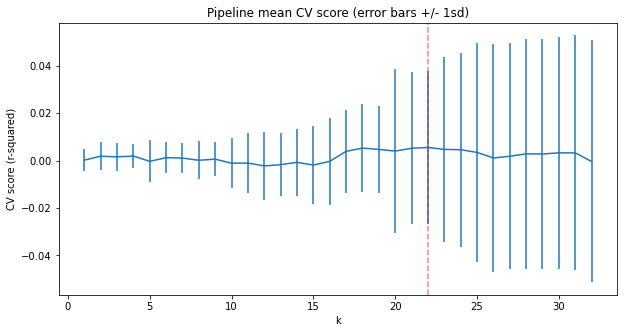

In [54]:
# plot the CV scores for each number of K
best_k = lm_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Findings
- the GridSearchCV returns the best number of features = 22
- plotting the CV scores against the number of features, however, reveals that the error bars for all scores include 0. The error bars also increase significantly in size as the number of features increases.

In [55]:
# lets get the features from our 'best' model
selected = lm_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [56]:
# print the selected feature names and their coefficients
coefs = lm_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = df_X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

TAVG_zone_2003_07            39.127106
TAVG_zone_1983_87            22.561912
TMIN_zone_2003_07            20.156101
PRCP_change_1973_2019        10.707197
TMAX_zone_1993_97             7.597126
TMIN_zone_1983_87             6.234279
TAVG_zone_2015_19             5.091965
TMIN_zone_2015_19             4.092244
TAVG_zone_sameyear            0.674562
TMIN_change_1973_sameyear     0.242501
TMAX_zone_sameyear           -0.157576
PRCP_zone_2003_07            -0.249284
TMAX_zone_1973_77            -0.322325
TAVG_zone_1973_77            -1.901021
TMIN_zone_sameyear           -2.656981
TMAX_zone_1983_87            -5.913457
TMAX_zone_2015_19            -6.375583
PRCP_zone_2015_19           -11.100125
TMIN_zone_1993_97           -13.842006
TMAX_zone_2003_07           -23.729398
TMIN_zone_1973_77           -23.755540
TAVG_zone_1993_97           -26.090736
dtype: float64

In our 'best' model (which does no better than predicting the mean) a large positive contribution is made by:
- TAVG_zone_2003_07
- TAVG_zone_1983_87
- TMIN_zone_2003_07
- PRCP_change_1973_2019

Large negative contributions are made by:
- TAVG_zone_1993_97
- TMIN_zone_1973_77
- TMAX_zone_2003_07
- TMIN_zone_1993_97

I'm hesitant to even pretend to draw conclusions from this as the model's performance is so poor. But if the performance were better, we could say that, on the whole, temperature seems to be affecting the death rate more than precipitation. 

## 5.5. Plotting Best Model

Below, we create a plot of observed outcomes vs predictions to visually evaluate the performance of our model.

In [128]:
best_linear_model = lm_grid_cv.best_estimator_

In [129]:
y_train_pred = best_linear_model.predict(X_train)
y_test_pred = best_linear_model.predict(X_test)

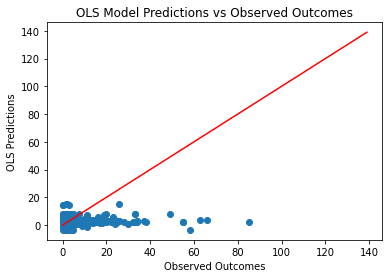

In [130]:
# Build a scatterplot of predictions vs observed outcomes
plt.scatter(y_test, y_test_pred)

# Add a line for perfect correlation. Can you see what this line is doing? Use plot()
plt.plot([x for x in range(0,140)],[x for x in range(0,140)], color='red')

# Label it nicely
plt.title('OLS Model Predictions vs Observed Outcomes')
plt.xlabel('Observed Outcomes')
plt.ylabel('OLS Predictions');

Unsurprisingly, the observed outcomes and predictions don't match up at all.

Finally, let's get the MAE and MSE of this K=22 best features model as well.

In [171]:
# get mean r2 score of best model
mean_r2_lm_kbest = score_mean[21]
mean_r2_lm_kbest

0.005565139857357582

In [131]:
# calculate mean absolute error on train and test sets
mae_lm_kbest = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
mae_lm_kbest

(1.951235536244939, 2.013456418659252)

In [132]:
# calculate mean squared error on train and test sets
mse_lm_kbest = mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)
mse_lm_kbest

(19.179214337902994, 16.669937326132956)

Looking at the r2 scores, MAE and MSE, we see that this model (with K=22 best features) performs worse than the Linear Regression model containing all 32 features. 

# 6. Model 2: Random Forest Regression

Next, let's see if we can do any better by using a different model: the Random Forest Regression.

## 6.1. Default RF Model

In [138]:
# let's define our pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=21)
)

In [139]:
%%time
# cross-validate the pipeline with 5 folds
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

CPU times: user 17.2 s, sys: 316 ms, total: 17.5 s
Wall time: 19 s


In [140]:
# get the cross-validation scores
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([ 0.03446479, -0.04452133, -0.46165177,  0.02684697,  0.02097913])

In [141]:
# get the mean score and std
mean_r2_rf = np.mean(rf_cv_scores)
std_r2_rf = np.std(rf_cv_scores)
mean_r2_rf, std_r2_rf

(-0.0847764413057532, 0.1905350269741462)

In [145]:
# fit pipeline to training set
RF_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=21))])

In [146]:
# predict target features
y_train_pred = RF_pipe.predict(X_train)
y_test_pred = RF_pipe.predict(X_test)

Let's also get the MAE and MSE

In [147]:
# calculate mean absolute error on train and test sets
mae_rf = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
mae_rf

(1.7558953618145683, 1.902240255949061)

In [148]:
# calculate mean squared error on train and test sets
mse_rf = mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)
mse_rf

(15.954868091786093, 15.679589593839097)

The mean r2 score of the 5-fold cross-validation of the default Random Forest Regression model is -0.08. This means it does *worse* than our baseline model which just predicts the mean value.

The MAE and MSE are better than the baseline model, however. And also better than our Linear Regression models.

## 6.2. Hyperparameter Tuning

Below, we conduct hyperparameter tuning using GridSearchCV to try and tweak our RF model/

Specifically, we will tune:
- the number of trees (estimator)
- scaling or not scaling the numerical data
- imputing using mean or median
- the function used to measure quality of a split (mae or mse)
- the max_depth of a tree

In [149]:
# let's define our pipeline
RF_pipe = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(random_state=21)
)

In [150]:
# set grid_parameters
n_est = [10, 20, 50, 100, 250, 500, 1000]
n_depth = np.arange(1,15)

grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'simpleimputer__strategy': ['mean'],
        'randomforestregressor__max_depth': n_depth
}

In [98]:
# set up GridSearchCV with RF pipeline
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [99]:
%%time
# fit GridSearch to training data
rf_grid_cv.fit(X_train, y_train)

CPU times: user 4.79 s, sys: 810 ms, total: 5.6 s
Wall time: 32min 59s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=21))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'randomforestregressor__n_estimators': [10, 20, 50,
                                                                 100, 250, 500,
                                                                 1000],
                         'simpleimputer__strategy': ['mean']})

In [151]:
# get cross-validation scores of best estimator
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([ 0.04089079, -0.03697872, -0.01788381,  0.04179175,  0.01538907])

In [159]:
# get mean score of best estimator and std
mean_r2_rf_tuned = np.mean(rf_best_scores)
mean_r2_rf_tuned, np.std(rf_best_scores)

(0.008641817126231733, 0.03152548929849423)

This is looking better than the untuned RF (but still bad).

Let's also get the MAE and MSE of the best RF estimator.

In [153]:
# get best estimator
best_RF = rf_grid_cv.best_estimator_

In [154]:
# get y_preds
y_train_pred = best_RF.predict(X_train)
y_test_pred = best_RF.predict(X_test)

In [157]:
# calculate mean absolute error on train and test sets
mae_rf_tuned = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
mae_rf_tuned

(1.941649713234935, 2.0010092611460664)

In [158]:
# calculate mean squared error on train and test sets
mse_rf_tuned = mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)
mse_rf_tuned

(19.222593737335167, 16.548373810913674)

Let's plot the feature importances of the best RF estimator.

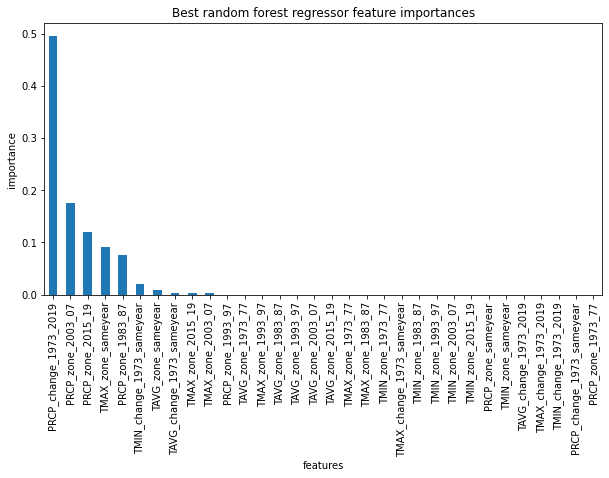

In [106]:
# plot the feature importances
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=df_X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [107]:
rf_feat_imps.head(6)

PRCP_change_1973_2019        0.496
PRCP_zone_2003_07            0.176
PRCP_zone_2015_19            0.120
TMAX_zone_sameyear           0.092
PRCP_zone_1983_87            0.076
TMIN_change_1973_sameyear    0.020
dtype: float64

### Interpretation

By tuning the hyperparameters of the RF Model, we have increased its performance as measured by the r2 score; from -0.08 to 0.008. This is still practically no better than simply predicting the mean, however. It is slightly better than the performance of our out-of-the-box Linear Regression model.

Plotting the features with the highest importances yields a slightly different set than the K-best features from our Linear Regression model. Noticeably, PRCP_change_1973_2019 is again included, so there seems to be some consistency to that.

Again, since the overall model performance is so poor, I hesitate to draw any conclusions from this at all.

# 7. Lasso Regression

We know from the EDA stage of this project that our climate features are highly correlated. For this reason, let's proceed to build a final model - Lasso Regression - that is particularly apt at dealing with this sort of situation.

In Lasso Regression, the regular OLS loss function is supplemented by ( alpha * the sum of the absolute values of the coefficients). In this way, Lasso penalizes the model for suggesting high predictor coefficients; i.e. **regularization**. Lasso will then also shrink the coefficients of unimportant features to zero and select only those features with coefficients other than 0.

In [108]:
# let's define our pipeline
Lasso_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    Lasso(random_state=21)
)

In [109]:
Lasso_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'lasso', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [110]:
# set grid_parameters
alpha = np.arange(0.1,1, step=0.05)
max_iter = [100, 200, 500, 750, 1000]

grid_params = {
        'lasso__alpha': alpha,
        'lasso__max_iter': max_iter
}

In [111]:
# set up GridSearchCV with RF pipeline
Lasso_grid_cv = GridSearchCV(Lasso_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [112]:
%%time
# fit GridSearch to training data
Lasso_grid_cv.fit(X_train, y_train)

CPU times: user 2.99 s, sys: 828 ms, total: 3.81 s
Wall time: 22.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=21))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'lasso__max_iter': [100, 200, 500, 750, 1000]})

In [160]:
# get cross-validation scores of best estimator
Lasso_best_cv_results = cross_validate(Lasso_grid_cv.best_estimator_, X_train, y_train, cv=5)
Lasso_best_scores = Lasso_best_cv_results['test_score']
Lasso_best_scores

array([ 0.00896701, -0.00168733,  0.00681987,  0.00551455,  0.00993369])

In [166]:
# get mean score of best estimator and std
mean_r2_Lasso = np.mean(Lasso_best_scores)
mean_r2_Lasso, np.std(Lasso_best_scores)

(0.005909558390890179, 0.004104608563778684)

Let's also get the MAE and MSE to compare with our baseline model.

In [162]:
# get best estimator
best_Lasso = Lasso_grid_cv.best_estimator_

In [191]:
best_Lasso.get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer(strategy='median')),
  ('standardscaler', StandardScaler()),
  ('lasso', Lasso(alpha=0.1, max_iter=100, random_state=21))],
 'verbose': False,
 'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler(),
 'lasso': Lasso(alpha=0.1, max_iter=100, random_state=21),
 'simpleimputer__add_indicator': False,
 'simpleimputer__copy': True,
 'simpleimputer__fill_value': None,
 'simpleimputer__missing_values': nan,
 'simpleimputer__strategy': 'median',
 'simpleimputer__verbose': 0,
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 0.1,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 100,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 21,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [163]:
# get y_preds
y_train_pred = best_Lasso.predict(X_train)
y_test_pred = best_Lasso.predict(X_test)

In [164]:
# calculate mean absolute error on train and test sets
mae_Lasso = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
mae_Lasso

(1.944534677651381, 1.9933175756071608)

In [165]:
# calculate mean squared error on train and test sets
mse_Lasso = mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)
mse_Lasso

(19.745853296415813, 16.425195913373305)

Let's get the coefficients of the features selected by the Lasso regression

In [119]:
# get feature coefficients of best Lasso estimator
coeffs = Lasso_grid_cv.best_estimator_.named_steps.lasso.coef_

In [120]:
Lasso_coeffs = pd.Series(coeffs, index=df_X_train.columns).sort_values(ascending=False)
Lasso_coeffs.head(5)

PRCP_change_1973_2019    0.251133
TAVG_change_1973_2019    0.029950
TMIN_change_1973_2019    0.003527
TMIN_zone_1973_77        0.000000
TAVG_zone_1983_87        0.000000
dtype: float64

### Interpretation
The best Lasso estimator has a 5-fold cross-validation mean r2 score of 0.006, which is comparable to the best RF estimator. Like the RF estimator, it is practically no better than guessing the mean.

Interestingly, the Lasso Regression reduces all but 3 of the feature coefficients to 0. These three features are the change in PRCP, TAVG and TMIN between 1973 and 2019 for each station.

Once again, it's hard to draw conclusions from a model that performs so poorly, but if the performance were better, this would be an interesting finding. The consistenct of the same interval (1973-2019) is at least remarkable.

The consistency of PRCP_change_1973_2019 across the three models is also noteworthy.

# 8. Model Selection

Below we create and display a dataframe containing the performance metrics of 6 models **on the test set**:
- baseline Dummy Regressor
- out-of-the-box Linear Regressor
- Linear Regressor with KBestFeatures
- out-of-the-box Random Forest Regressor
- tuned Random Forest Regressor
- tuned Lasso Regressor

In [177]:
data = [[r2_base[1], mae_base[1], mse_base[1]], 
        [mean_r2_lm_median, mae_lm_median[1], mse_lm_median[1]],
        [mean_r2_lm_kbest, mae_lm_kbest[1], mse_lm_kbest[1]],
        [mean_r2_rf, mae_rf[1], mse_rf[1]],
        [mean_r2_rf_tuned, mae_rf_tuned[1], mse_rf_tuned[1]],
        [mean_r2_Lasso, mae_Lasso[1], mse_Lasso[1]]
       ]

columns = ['R2', 'MAE', 'MSE']
index = ['Baseline', 'LinearReg', 'LinReg_KBest', 'RandomForest', 'RF_Tuned', 'Lasso_Tuned']

In [188]:
df_results = pd.DataFrame(data, columns=columns, index=index)
df_results = df_results.round(5)
df_results.reset_index(inplace=True)
df_results.columns = ['Model', 'R2', 'MAE', 'MSE']
df_results

,Model,R2,MAE,MSE
0,Baseline,-0.00018,2.00499,16.57384
1,LinearReg,-0.00032,1.96529,16.31134
2,LinReg_KBest,0.00557,2.01346,16.66994
3,RandomForest,-0.08478,1.90224,15.67959
4,RF_Tuned,0.00864,2.00101,16.54837
5,Lasso_Tuned,0.00591,1.99332,16.42520


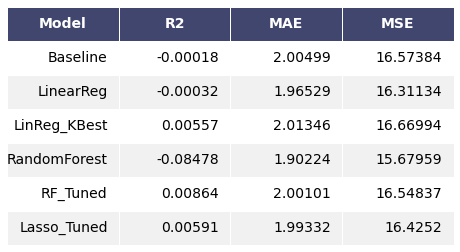

In [189]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df_results, header_columns=0, col_width=2.0)
fig.savefig("/Users/richard/Desktop/springboard_repo/capstones/capstone-two/reports/figures/Model_Results_Table.png")

Based on the analysis performed in this notebook and the overview of performance metrics above, our conclusion is that **it is not possible to accurately predict conflict intensity (measured in total death count) from the chosen predictor features**.

If we absolutely had to make a choice, we would select the out-of-the-box Linear Regression. This model does no better than predicting the mean in terms of r2, but does reduce the Mean Absolute Error somewhat. A second option could be the Lasso Regression model, which improves somewhat on the baseline model in terms of r2 score and the MAE, and has the additional value of requiring far less features, which could save both time and money in future data collection.